In [1]:
import os

In [2]:
os.chdir("../")

In [3]:
%pwd

'c:\\Users\\manob\\Documents\\Kidney_Disease_Detection\\Kidney_Disease_Detection'

In [4]:
from dataclasses import dataclass
from pathlib import Path

@dataclass(frozen=True)
class EvaluationConfig:
    root_dir: Path
    trained_model_path: Path
    training_data: Path
    params_image_size: list
    params_batch_size: int

In [5]:
import os
from dataclasses import dataclass
from pathlib import Path
from cnnClassifier.constants import *
from cnnClassifier.utils.common import read_yaml, create_directories, save_json
import tensorflow as tf
from cnnClassifier.entity.config_entity import EvaluationConfig
from cnnClassifier.logger import logger
import numpy as np
import json
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score





c:\Users\manob\Documents\Kidney_Disease_Detection\Kidney_Disease_Detection\.conda\Lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\manob\Documents\Kidney_Disease_Detection\Kidney_Disease_Detection\.conda\Lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
c:\Users\manob\Documents\Kidney_Disease_Detection\Kidney_Disease_Detection\.conda\Lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [6]:
class ConfigurationManager:
    def __init__(
        self,
        config_filepath=CONFIG_FILE_PATH,
        params_filepath=PARAMS_FILE_PATH):
        
        self.config = read_yaml(config_filepath)
        self.params = read_yaml(params_filepath)
        create_directories([self.config.artifacts_root])

    def get_evaluation_config(self) -> EvaluationConfig:
        training_config = self.config.training
        eval_config = self.config.model_evaluation

        create_directories([Path(eval_config.root_dir)])

        evaluation_config = EvaluationConfig(
            root_dir=Path(eval_config.root_dir),
            trained_model_path=Path(training_config.trained_model_path),
            training_data=Path(training_config.training_data),
            params_image_size=self.params.IMAGE_SIZE,
            params_batch_size=self.params.BATCH_SIZE
        )
        return evaluation_config

In [7]:
# Evaluation Class
class Evaluation:
    def __init__(self, config: EvaluationConfig):
        self.config = config
        self.model = None
        self.valid_generator = None

    def load_model(self):
        """Load the trained model"""
        logger.info(f"Loading trained model from {self.config.trained_model_path}")
        self.model = tf.keras.models.load_model(self.config.trained_model_path)
        logger.info("Model loaded successfully")

    def create_validation_generator(self):
        """Create validation data generator"""
        logger.info("Creating validation data generator...")

        datagenerator_kwargs = dict(
            rescale=1./255,
            validation_split=0.20
        )

        dataflow_kwargs = dict(
            target_size=self.config.params_image_size[:-1],
            batch_size=self.config.params_batch_size,
            class_mode="binary",
            interpolation="bilinear"
        )

        valid_datagenerator = tf.keras.preprocessing.image.ImageDataGenerator(
            **datagenerator_kwargs
        )

        # Use the combined training data directory created during training
        combined_training_dir = "artifacts/data_ingestion/Combined_Training_Data"

        self.valid_generator = valid_datagenerator.flow_from_directory(
            directory=combined_training_dir,
            subset="validation",
            shuffle=False,
            **dataflow_kwargs
        )
        logger.info(f"Validation generator created with {self.valid_generator.samples} samples")

    def evaluate(self):
        """Evaluate the model and log metrics"""
        logger.info("Starting model evaluation...")

        # Ensure model and generator are initialized
        if self.model is None:
            self.load_model()
        if self.valid_generator is None:
            self.create_validation_generator()
            
        # Evaluate the model
        scores = self.model.evaluate(self.valid_generator)
        logger.info(f"Validation Loss: {scores[0]:.4f}")
        logger.info(f"Validation Accuracy: {scores[1]:.4f}")
        
        # Generate predictions
        predictions = self.model.predict(self.valid_generator)
        y_pred = (predictions > 0.5).astype(int).flatten()
        y_true = self.valid_generator.classes
        
        # Classification Report
        report = classification_report(y_true, y_pred, target_names=['Non-Stone', 'Stone'])
        logger.info("Classification Report:\n" + report)

        # Confusion Matrix
        cm = confusion_matrix(y_true, y_pred)
        logger.info("Confusion Matrix:\n" + str(cm))
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Stone', 'Stone'], yticklabels=['Non-Stone', 'Stone'])
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.tight_layout()
        plt.show()

        # Save evaluation metrics
        metrics = {
            "loss": float(scores[0]),
            "accuracy": float(scores[1]),
            "classification_report": report,
            "confusion_matrix": cm.tolist()
        }
        save_path = self.config.root_dir / "evaluation_metrics.json"
        with open(save_path, 'w') as f:
            json.dump(metrics, f, indent=4)
        logger.info(f"Evaluation metrics saved to {save_path}")

        # === ROC and Precision-Recall Curve ===
        y_scores = predictions.flatten()

        # ROC Curve
        fpr, tpr, _ = roc_curve(y_true, y_scores)
        roc_auc = auc(fpr, tpr)

        plt.figure()
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("ROC Curve")
        plt.legend(loc="lower right")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        # Precision-Recall Curve
        precision, recall, _ = precision_recall_curve(y_true, y_scores)
        average_precision = average_precision_score(y_true, y_scores)

        plt.figure()
        plt.plot(recall, precision, color='green', lw=2, label=f'Avg Precision = {average_precision:.2f}')
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.title("Precision-Recall Curve")
        plt.legend(loc="lower left")
        plt.grid(True)
        plt.tight_layout()
        plt.show()


    def save_model(self, path: Path):
        """Save the evaluated model if needed"""
        self.model.save(path)
        logger.info(f"Model saved at {path}")



[2025-03-24 11:46:43,727: INFO: common: yaml file: config\config.yaml loaded successfully]
[2025-03-24 11:46:43,730: INFO: common: yaml file: params.yaml loaded successfully]
[2025-03-24 11:46:43,730: INFO: common: created directory at: artifacts]
[2025-03-24 11:46:43,730: INFO: common: created directory at: artifacts\evaluation]
[2025-03-24 11:46:43,730: INFO: 1334227333: Loading trained model from artifacts\training\model.h5]
[2025-03-24 11:46:44,325: INFO: 1334227333: Model loaded successfully]
[2025-03-24 11:46:44,325: INFO: 1334227333: Creating validation data generator...]
Found 14187 images belonging to 2 classes.
[2025-03-24 11:46:44,721: INFO: 1334227333: Validation generator created with 14187 samples]
[2025-03-24 11:46:44,721: INFO: 1334227333: Starting model evaluation...]
444/444 [==============================] - 148s 332ms/step - loss: 0.3955 - accuracy: 0.8199
[2025-03-24 11:49:12,842: INFO: 1334227333: Validation Loss: 0.3955]
[2025-03-24 11:49:12,843: INFO: 1334227333

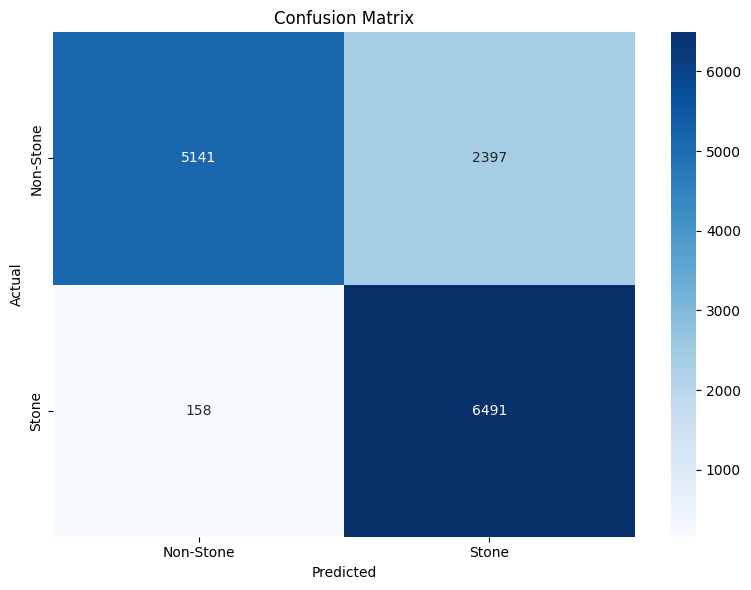

[2025-03-24 11:51:39,748: INFO: 1334227333: Evaluation metrics saved to artifacts\evaluation\evaluation_metrics.json]


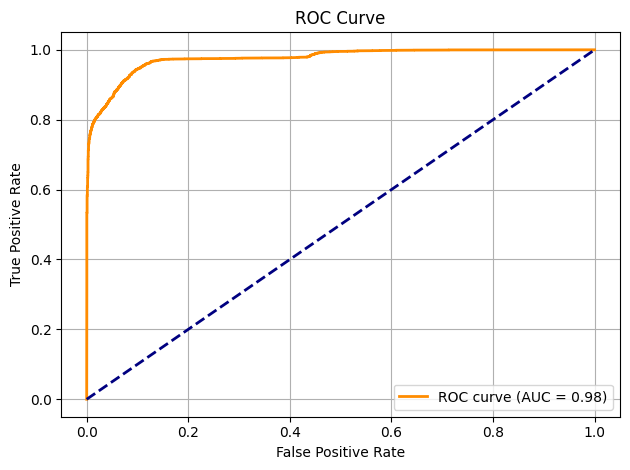

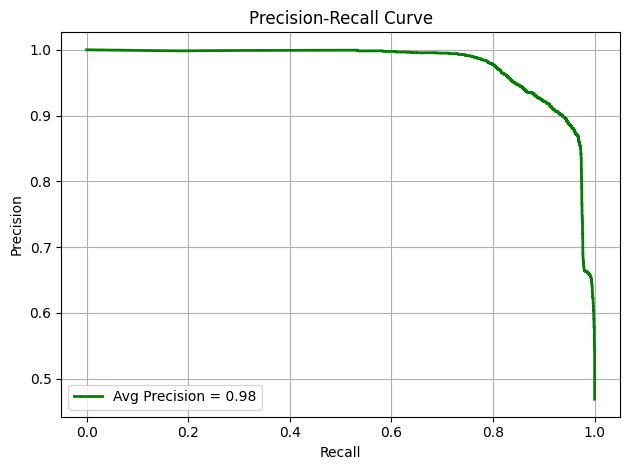

In [8]:
if __name__ == "__main__":
    try:
        config = ConfigurationManager()
        evaluation_config = config.get_evaluation_config()
        evaluation = Evaluation(config=evaluation_config)
        evaluation.load_model()
        evaluation.create_validation_generator()
        evaluation.evaluate()
    except Exception as e:
        logger.error(f"Error during evaluation: {e}")
        raise e

# Evaluation Class
class Evaluation:
    def __init__(self, config: EvaluationConfig):
        self.config = config
        self.model = None
        self.valid_generator = None

    def load_model(self):
        """Load the trained model"""
        logger.info(f"Loading trained model from {self.config.trained_model_path}")
        self.model = tf.keras.models.load_model(self.config.trained_model_path)
        logger.info("Model loaded successfully")

    def create_validation_generator(self):
        """Create validation data generator"""
        logger.info("Creating validation data generator...")

        datagenerator_kwargs = dict(
            rescale=1./255,
            validation_split=0.20
        )

        dataflow_kwargs = dict(
            target_size=self.config.params_image_size[:-1],
            batch_size=self.config.params_batch_size,
            class_mode="binary",
            interpolation="bilinear"
        )

        valid_datagenerator = tf.keras.preprocessing.image.ImageDataGenerator(
            **datagenerator_kwargs
        )

        # Use the combined training data directory created during training
        combined_training_dir = "artifacts/data_ingestion/Combined_Training_Data"

        self.valid_generator = valid_datagenerator.flow_from_directory(
            directory=combined_training_dir,
            subset="validation",
            shuffle=False,
            **dataflow_kwargs
        )
        logger.info(f"Validation generator created with {self.valid_generator.samples} samples")

    def evaluate(self):
        """Evaluate the model and log metrics"""
        logger.info("Starting model evaluation...")

        # Ensure model and generator are initialized
        if self.model is None:
            self.load_model()
        if self.valid_generator is None:
            self.create_validation_generator()
            
        # Evaluate the model
        scores = self.model.evaluate(self.valid_generator)
        logger.info(f"Validation Loss: {scores[0]:.4f}")
        logger.info(f"Validation Accuracy: {scores[1]:.4f}")
        
        # Generate predictions
        predictions = self.model.predict(self.valid_generator)
        y_pred = (predictions > 0.5).astype(int).flatten()
        y_true = self.valid_generator.classes
        
        # Classification Report
        report = classification_report(y_true, y_pred, target_names=['Non-Stone', 'Stone'])
        logger.info("Classification Report:\n" + report)

        # Confusion Matrix
        cm = confusion_matrix(y_true, y_pred)
        logger.info("Confusion Matrix:\n" + str(cm))
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.tight_layout()
        plt.show()

        # Save evaluation metrics
        metrics = {
            "loss": float(scores[0]),
            "accuracy": float(scores[1]),
            "classification_report": report,
            "confusion_matrix": cm.tolist()
        }
        save_path = self.config.root_dir / "evaluation_metrics.json"
        with open(save_path, 'w') as f:
            json.dump(metrics, f, indent=4)
        logger.info(f"Evaluation metrics saved to {save_path}")

    def save_model(self, path: Path):
        """Save the evaluated model if needed"""
        self.model.save(path)
        logger.info(f"Model saved at {path}")